In this project we will try to regenerate original video whose frames have been reshuffle. We will first read a video in its original form and then randomly shuffle frames and then using Machine Learning and Statistics will try to reorder frames to regenerate original video.
We can do pixel to pixel comparison to group frames which are similar to each other by calculating distance between corresponding pixels but it has 2 limitations. we can get distance between frames but we don't know how to arrange them, and secondly if camera moves pixel corresponding to particular object will be in different positions and we will get larger distance between two frames which are similar to each other but taken at a slightly different angle.
Instead of comparing pixels we can compare features of an image.

INCEPTION

Model likes Inception are trained on huge data to classify images. They do so by various convolution layers and then fully connected layers 
in the later part. We can use these later fully connected layers which contains information of different feature. The final fully connected 
layers is an array of numbers of length 2048. These 2048 numbers are not interpretable but we can assume each of these numbers conveys some information of a feature. For instance, one of the number may correspond to how much of chance of having a human in a given image and other number may correspond to how much of a chance of a given image having a car. So we can assume 1st value of this array is for human and high value means there are higher chance of having a person in this image and low value will correspond to a lower chance. Similarly 2nd value can be assumed to be of a car and so on. So instead of comparing pixels we will compare feature vector where compared value won’t be affected by much if camera angle changes as the features value of an image like human, car remain the same if the camera angle are slightly different for different frames. Meaning if there is a car in the image taken from slightly different angle our feature vector will still detect car with almost equal probability and thus the value corresponding to a car in the feature vector will still be similar and so would be distance between frames

TSNE 

TSNE takes data of m dimension and reduces the dimesion to as low as 1. It reduces dimesion based on similarity. Data which are closer to each other in m dimesion are more similar to each other and are grouped together in lower dimesion. It gives similar values to Data which are closer to each other and values changes as data gets farther from each other. We can use this concept to arrange frames which are in 2048 dimesion after passing from Inception layer to reduce them to 1 dimesion We can then arrange this data as per TSNE values and hopefully we will be able to get proper sequence.

In [ ]:
import keras.applications
#from keras.applications import inception_resnet_v2
from keras.applications import inception_v3
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from numpy.random import seed
import cv2
import os


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Reading Video and creating a list

In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
vid = cv2.VideoCapture('video.avi')
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame=0
list1=[]
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    img = cv2.resize(img, (299, 299)) #resizing to 299,299 as a requirement for inception model
    list1.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #video and images are read after flipping 1st and 3rd  channel in opencv so before saving in a list 
                                                       #we need to do reverse flipping by cv2.COLOR_BGR2RGB to make it make to RGB mode
    frame=frame+1
    

Completed


In [ ]:
print(len(list1))
print(frame)
len(list1)==frame #checking if all frames are store in list

350
350


True

In [ ]:
img_array=np.array(list1)  #converting list to array
img_array.shape

(350, 299, 299, 3)

To run and watch video output we will use a seperate file which we will write and execute in our own system as this script is written in colab. We will save all the videos in a pickle file and then fetch these pickle files in our own system to play video

In [ ]:
#original video
from pickle import dump,load
filename = r'original_video.pkl'
dump(img_array, open(filename, 'wb'))

INCEPTION - Running inception model to get encodings of each frame

In [ ]:
inception_v3_model = inception_v3.InceptionV3(include_top=True,weights="imagenet")
#inception_v3_model.summary()
model_inceptionv3 = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)


In [ ]:
img_encoded = preprocess_input(img_array)
img_encoded = model_inceptionv3.predict(img_encoded)
#x = np.reshape(x, x.shape[1])
print(img_encoded.shape)

(350, 2048)


TSNE - passing the encoded vectors to TSNE

We will first pass the vector for orignal video to check if there is a relation between frame and TSNE output. If there is no relation between frames and TSNE output we won't be able to use TSNE to reorder frames.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1, verbose=1, perplexity=40, n_iter=2000,random_state=150)
tsne_results = tsne.fit_transform(img_encoded)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.038s...
[t-SNE] Computed neighbors for 350 samples in 0.490s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 4.186991
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.514709
[t-SNE] KL divergence after 1700 iterations: 0.359083


Ploting output of TSNE in Y axis and frame number in X axis

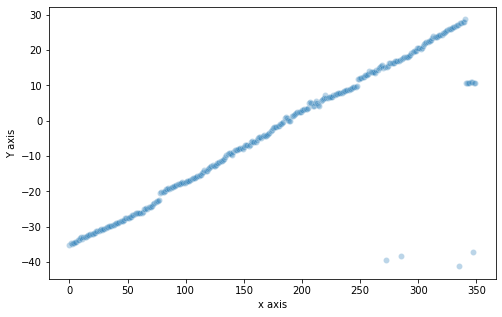

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
df = pd.DataFrame({'x axis':np.arange(tsne_results.shape[0]),'Y axis':tsne_results[:,0]})


plt.figure(figsize=(8,5))
sns.scatterplot(
    x="x axis", y="Y axis",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

As we can see from graph that there is a relation between frame and TSNE output. There is infact a high positive correlation. Initial frames have lower value and as new frames keep coming up values keeps increasing 

So we can use this information when frame is not in sequence. We will see no relation between the output and out of order frames but we know from above graph that lower values corresponds to initial frames and higher value corresponds to later frame. so we can just sort the TSNE results in ascending order to get proper frame sequence.

In [ ]:
print(tsne_results.min())
print(tsne_results.max())
tsne_results.shape


-41.251568
28.666126


(350, 1)

In [ ]:
reorder_id=np.argsort(tsne_results.squeeze()) #sorting the frame sequence as per TSNE values in ascending order, getting IDs(frame number)
print(reorder_id)

[335 272 285 347   0   2   1   3   4   5   6   7   8  11   9  13  10  12
  14  15  16  17  18  19  20  21  22  23  25  24  26  28  29  27  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50
  48  51  52  53  54  55  56  57  58  61  60  59  62  63  64  65  67  66
  70  68  69  71  72  73  74  75  76  77  78  79  81  80  82  86  83  84
  87  85  88  89  90  91  92  93  95  94  99  96  98  97 100 102 101 103
 104 105 107 106 108 109 110 111 112 113 114 115 118 117 116 119 120 121
 122 125 124 123 126 127 128 129 130 131 132 133 134 140 135 139 136 137
 138 141 142 143 144 145 149 146 147 148 150 154 151 152 153 155 159 156
 158 160 157 161 162 165 163 164 166 168 169 167 170 171 172 173 174 175
 177 176 178 179 180 181 182 183 184 189 190 188 185 187 186 191 192 193
 194 195 198 196 197 199 201 200 202 203 204 205 210 215 209 214 206 213
 211 208 207 216 212 217 218 219 221 222 224 223 226 225 220 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 24

In [ ]:
#Creating new video as per TSNE results , frames with lower value will be placed before frames with higher values 
img_array_result_list=[]
for i,j in enumerate(reorder_id):
    img_array_result_list.append(img_array[j])
img_array_result=np.array(img_array_result_list)    
img_array_result.shape

(350, 299, 299, 3)

In [ ]:
#output video generated from original video, storing in a pickle file
from pickle import dump,load
filename = r'original_video_result.pkl'
dump(img_array_result, open(filename, 'wb'))




We got good results on original video now lets try on shuffled video frame

In [ ]:
#creating a new array with length same as number of frame but in random order where values are shuffle between 0 and total number of frames
#each value corresponds to frame number so first value is 61 so 61st frame will be our first frame and so on
seed(50)
arr = np.arange(len(list1))
np.random.shuffle(arr)
arr=arr.tolist()
print(arr,len(arr))

[61, 208, 103, 168, 232, 167, 304, 86, 63, 88, 235, 344, 67, 11, 330, 136, 294, 126, 89, 252, 210, 98, 29, 121, 148, 87, 107, 31, 162, 182, 314, 269, 46, 219, 230, 3, 236, 1, 16, 124, 161, 338, 166, 305, 77, 90, 102, 44, 284, 195, 81, 270, 8, 248, 20, 108, 214, 160, 254, 114, 322, 247, 34, 159, 65, 50, 243, 151, 196, 318, 73, 257, 222, 286, 157, 203, 141, 341, 145, 340, 251, 97, 146, 231, 74, 25, 317, 268, 115, 212, 99, 48, 43, 306, 292, 85, 234, 15, 100, 310, 37, 307, 18, 342, 244, 153, 185, 226, 9, 331, 66, 24, 328, 204, 112, 127, 180, 39, 311, 135, 259, 297, 227, 279, 19, 198, 84, 260, 321, 138, 41, 144, 72, 82, 10, 274, 215, 200, 207, 183, 191, 32, 202, 83, 33, 217, 295, 181, 201, 53, 158, 175, 76, 290, 12, 177, 245, 209, 119, 329, 129, 69, 253, 123, 249, 38, 23, 178, 239, 125, 213, 283, 261, 319, 308, 96, 188, 327, 40, 280, 172, 194, 42, 348, 313, 298, 316, 122, 170, 140, 190, 59, 255, 35, 216, 205, 149, 179, 291, 21, 113, 301, 54, 120, 276, 169, 238, 246, 28, 263, 206, 349, 324, 

In [ ]:
#creating a new video where frames have been shuffled
img_shuffle_list=[]
for i,j in enumerate(arr):
    img_shuffle_list.append(img_array[j])
img_shuffle=np.array(img_shuffle_list)    
print(img_shuffle.shape)    

(350, 299, 299, 3)


In [ ]:
#saving the shuffle video in a pickle file
from pickle import dump,load
filename = r'shuffle_video.pkl'
dump(img_shuffle, open(filename, 'wb'))




In [ ]:
#just to make sure shuffling was done properly and no frames was lost we are generating back original video from shuffled video 
#which we are saving in a  pickle file
dict1 = dict(zip(arr, img_shuffle))
sorted_items = sorted(dict1.items())
img_shuffle_dummy=np.array((list(dict(sorted_items).values())))
print(img_shuffle_dummy.shape)
 
comparison = img_shuffle_dummy == img_array
equal_arrays = comparison.all()
print(equal_arrays)

#original video and video reshuffled back from shuffled video are same. we can confirm shuffling was done properly with no information lost

(350, 299, 299, 3)
True


Creating encoding vectors of shuffled video after passing it through inception layer

In [ ]:
inception_v3_model = inception_v3.InceptionV3(include_top=True,weights="imagenet")
#inception_v3_model.summary()
model_inceptionv3 = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)


In [ ]:
img_shuffle_encoded = preprocess_input(img_shuffle)
img_shuffle_encoded = model_inceptionv3.predict(img_shuffle_encoded)
print(img_shuffle_encoded.shape)



(350, 2048)


Passing the encoded vector through TSNE

In [ ]:
from sklearn.manifold import TSNE
tsne_reorder = TSNE(n_components=1, verbose=1, perplexity=40, n_iter=2000,random_state=150)
tsne_reorder_results = tsne_reorder.fit_transform(img_shuffle_encoded)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.033s...
[t-SNE] Computed neighbors for 350 samples in 0.458s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 4.186987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.631660
[t-SNE] KL divergence after 1700 iterations: 0.231914


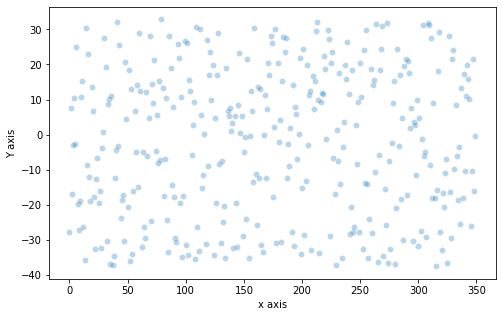

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
df = pd.DataFrame({'x axis':np.arange(tsne_reorder_results.shape[0]),'Y axis':tsne_reorder_results[:,0]})


plt.figure(figsize=(8,5))
sns.scatterplot(
    x="x axis", y="Y axis",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

As we can see no pattern which we were expecting as frames are out of order

In [ ]:
print(tsne_reorder_results.min())
print(tsne_reorder_results.max())
tsne_reorder_results.shape

-37.575275
32.870728


(350, 1)

In [ ]:
#sorting the frame sequence as per TSNE values in ascending order, getting ids (frame number)
reorder_id=np.argsort(tsne_reorder_results.squeeze())
print(reorder_id)

[315 229  37  35 280 274 325 265  52  13 108 234 134 154 257  97  38 270
 102 124  54 199 215 166  85 111 320 208  22 276 252  27 141 144  62 193
 300 100 165 117 178 130 182  92  47 295  32 287 328  65  91 307 224 149
 202 241 260 249 244   0 319 191 302   8 245  64  12 110 345 272 161 336
 132  70  84 258 152  44 281 322  50 242 133   7 143 126  25  95   9  18
  45 334 285 314 338 312  90 175  21  81  98  46 290   2 228 321 327  26
  55 348 316 271 114 200  59  88 233 256 254 158 203  23 187 169  39 163
  17 115 298 160 323 263 346 340 331 189 119 310  15 247 129  76 231 275
 131  78 196  82 324  24 227 333  67 305 105 266  63 306 150  57  74  40
  28 235 335 283  42   3 205   5 188 277 180 221 303 151 155 349 167 197
 116 147  29 139 230 293 190 176 106 297 246 140 296 236 181  49 125  68
 286 301 148 137 142  75 113 195  20 136 157  56 210 170 294   1 138 194
  89 145 332  33 313  72 278 248 107 216 214 122 299 344  34  83   4 251
  96  10  36 341 206 168 240 218 217  66 104 156 20

In [ ]:
#Creating new video as per TSNE results , frames with lower value will be placed before frames with higher values 

img_shuffle_result_list=[]
for i,j in enumerate(reorder_id):
    img_shuffle_result_list.append(img_shuffle[j])
img_shuffle_result=np.array(img_shuffle_result_list)    

In [ ]:
#output video generated from out of shuffle frame, storing in a pickle file
from pickle import dump,load
filename = r'video_shuffle_result.pkl'
dump(img_shuffle_result, open(filename, 'wb'))

In [ ]:
#refer file Play_video to play video